In [1]:
# !pip install pyarabic
# !pip install datasets
# !pip install transformers
# !pip install -U accelerate
# !pip install optuna

In [2]:
import pickle
import nltk
from pyarabic import araby
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datasets import Dataset

In [3]:
with open('train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('test.pkl', 'rb') as f:
    X_test = pickle.load(f)

In [4]:
X_train.head()

,tweet,label,tweet_with_out_emojis,cleaned_data,Light Stemming,Root Stemming
5322,انا مو بس احبگ انا ميّت عليك😴 فَقْدتگ تذْبح وت...,4,انا مو بس احبگ انا ميّت عليك فَقْدتگ تذْبح و...,انا مو احبگ انا ميت فقدتگ تذبح وتنكد علي يومي ...,انا مو احبگ انا ميت فقدتگ تذبح وتنكد علي يومي ...,انا مو حبگ انا ميت قدتگ ذبح نكد علي يوم حزن اح...
8900,علي ان باقي لي اختبارين قدرات بس خايفه بشكل مُ...,7,علي ان باقي لي اختبارين قدرات بس خايفه بشكل مُ...,علي ان باقي اختبارين قدرات خايفه بشكل مبالغ ال...,علي ان باقي اختبارين قدرات خايفه بشكل مبالغ اخ...,علي ان بقي خبر قدر خيف شكل بلغ خبر خوف ودي ابك...
7092,هي الاوليمبياد هتخلص امتي؟,0,هي الاوليمبياد هتخلص امتي؟,الاوليمبياد هتخلص امتي,اوليمبياد هتخلص امتي,اوليمبياد هتخلص امت
2694,;; الخوف اللي يخليك مش عارف تفرح دا من اسخف ال...,7,;; الخوف اللي يخليك مش عارف تفرح دا من اسخف ال...,الخوف اللي يخليك مش عارف تفرح دا اسخف الحاجات ...,خوف اللي يخليك مش عارف تفرح دا اسخف حاجات دنيا,خوف الل يخل مش عرف فرح دا سخف حاج دنا
5661,بعد الاوليمبياد ده غالبا احنا اللي هيتقالنا ع ...,7,بعد الاوليمبياد ده غالبا احنا اللي هيتقالنا ع ...,الاوليمبياد ده احنا اللي هيتقالنا المطبخ,اوليمبياد ده احنا اللي هيتقالنا مطبخ,اوليمبياد ده احن الل هيتقال طبخ


In [5]:
X_train['length'] = X_train['Root Stemming'].apply(lambda x:len(araby.tokenize(x)))

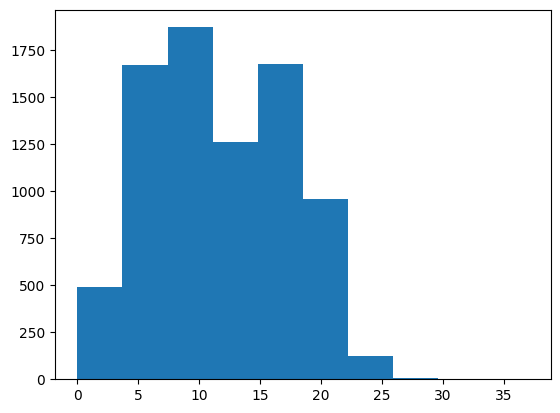

In [6]:
#histogram of tweets lengthes
plt.hist(X_train['length'])
plt.show()

In [7]:
sorted(X_train.query("length > 25")['length'].values)

[26, 26, 26, 26, 27, 27, 27, 34, 37]

In [8]:
X_train = X_train[['Root Stemming', 'label']]
y_train = X_train['label']
X_test = X_test[['Root Stemming', 'label']]
y_test = X_test['label']

In [9]:
X_train.shape, X_test.shape

((8052, 2), (2013, 2))

In [10]:
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

In [11]:
X_test.shape, X_dev.shape

((1006, 2), (1007, 2))

In [12]:
X_train

,Root Stemming,label
5322,انا مو حبگ انا ميت قدتگ ذبح نكد علي يوم حزن اح...,4
8900,علي ان بقي خبر قدر خيف شكل بلغ خبر خوف ودي ابك...,7
7092,اوليمبياد هتخلص امت,0
2694,خوف الل يخل مش عرف فرح دا سخف حاج دنا,7
5661,اوليمبياد ده احن الل هيتقال طبخ,7
...,...,...
17,كنت نفس تبن دنا طعم تني حجه انه,3
2410,وكل عمق بتفاصيلك كثر زدد جنو بك,4
6829,ديكتاتوري دمر خلق غلب شعب تحل الي كئن فسد لان ...,1
3872,مهم كننز ما هربيش مش عشن زهق مني انستجرام ماتس...,2


In [13]:
X_train = X_train.rename_axis('id')
X_test = X_test.rename_axis('id')
X_dev = X_dev.rename_axis('id')

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_dev = X_dev.reset_index(drop=True)

In [14]:
X_train = Dataset.from_pandas(X_train)
X_test = Dataset.from_pandas(X_test)
X_dev = Dataset.from_pandas(X_dev)
X_train, X_test, X_dev

(Dataset({
     features: ['Root Stemming', 'label'],
     num_rows: 8052
 }),
 Dataset({
     features: ['Root Stemming', 'label'],
     num_rows: 1006
 }),
 Dataset({
     features: ['Root Stemming', 'label'],
     num_rows: 1007
 }))

In [15]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_checkpoint = "asafaya/bert-base-arabic"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [16]:
model_init = lambda: AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=8)

In [17]:
def tokenize_function(examples):
    return tokenizer(examples["Root Stemming"], padding="max_length", truncation=True, max_length=37)

X_train = X_train.map(tokenize_function, batched=True, num_proc = 8)
X_dev = X_test.map(tokenize_function, batched=True, num_proc = 8)
X_test = X_test.map(tokenize_function, batched=True, num_proc = 8)

Map (num_proc=8):   0%|          | 0/8052 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1006 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1006 [00:00<?, ? examples/s]

In [18]:
X_train

Dataset({
    features: ['Root Stemming', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8052
})

In [19]:
import numpy as np
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             confusion_matrix,
                             precision_score,
                             recall_score
                             )

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)

    macro_f1 = f1_score(p.label_ids,preds,average='macro', zero_division=1)
    macro_precision = precision_score(p.label_ids,preds,average='macro', zero_division=1)
    macro_recall = recall_score(p.label_ids,preds,average='macro', zero_division=1)
    acc = accuracy_score(p.label_ids,preds)
    return {
      'macro_f1' : macro_f1,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
    }

In [20]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, IntervalStrategy

batch_size = 32
logging_steps = 100

training_args = TrainingArguments(output_dir="./train")
training_args.do_train = True
training_args.evaluate_during_training = True
# training_args.per_device_train_batch_size = batch_size
# training_args.per_device_eval_batch_size = batch_size
training_args.evaluation_strategy = IntervalStrategy.STEPS
# training_args.num_train_epochs = num_epochs
training_args.logging_steps = logging_steps
training_args.eval_steps = logging_steps
training_args.save_steps = 500
training_args.save_total_limit = 5
# training_args.seed = 42
training_args.load_best_model_at_end=True
training_args.metric_for_best_model = 'macro_f1'

In [21]:
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=X_train,
    eval_dataset=X_dev,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")
best_run

[I 2023-08-08 06:52:39,569] A new study created in memory with name: no-name-4692e6a5-58e8-421b-a5ee-7c921a3c8adb
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.922000,1.646674,0.284520,0.664075,0.397186,0.421471
200,1.533800,1.325576,0.489894,0.525776,0.530923,0.546720
300,1.395200,1.264357,0.542018,0.574862,0.551634,0.551690
400,1.217600,1.207112,0.561216,0.619301,0.578628,0.593439
500,1.213300,1.220196,0.552101,0.606039,0.589564,0.596421
600,1.127000,1.179411,0.566141,0.641792,0.599285,0.611332
700,1.279800,1.232505,0.529972,0.648630,0.553474,0.569583
800,1.152600,1.132105,0.621216,0.652530,0.622718,0.634195
900,1.246600,1.137889,0.591366,0.662177,0.608780,0.616302
1000,1.213100,1.064226,0.603459,0.662031,0.627315,0.637177


[I 2023-08-08 06:54:48,920] Trial 0 finished with value: 2.5299811055576935 and parameters: {'learning_rate': 3.061591335050048e-05, 'num_train_epochs': 4, 'seed': 5, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 2.5299811055576935.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,2.109400,2.048702,0.131877,0.285411,0.207042,0.230616
200,2.022300,1.984439,0.202205,0.482040,0.269724,0.300199
300,1.963600,1.864587,0.334708,0.389234,0.406744,0.421471
400,1.851900,1.751783,0.331653,0.412798,0.409331,0.426441
500,1.782300,1.700095,0.336220,0.398330,0.401838,0.419483
600,1.703000,1.632291,0.392415,0.382015,0.452678,0.466203
700,1.656900,1.570363,0.411238,0.489209,0.463074,0.481113
800,1.580800,1.521732,0.424779,0.488139,0.486711,0.501988


[I 2023-08-08 06:57:03,645] Trial 1 finished with value: 1.9016172356767642 and parameters: {'learning_rate': 1.6457483105359305e-06, 'num_train_epochs': 4, 'seed': 20, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 2.5299811055576935.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,2.027600,1.904396,0.236249,0.665982,0.290714,0.312127
200,1.803200,1.589055,0.386149,0.591709,0.463200,0.484095
300,1.508100,1.547559,0.376453,0.598335,0.453513,0.471173
400,1.470200,1.406211,0.467837,0.589339,0.519501,0.534791
500,1.434400,1.322694,0.519850,0.543507,0.549157,0.563618
600,1.389100,1.271053,0.529988,0.549348,0.556171,0.568588
700,1.297900,1.247370,0.542686,0.549758,0.558790,0.568588
800,1.259600,1.217299,0.553250,0.573682,0.573730,0.586481


[I 2023-08-08 06:58:40,354] Trial 2 finished with value: 2.28714282376088 and parameters: {'learning_rate': 6.03294302137426e-06, 'num_train_epochs': 1, 'seed': 39, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 2.5299811055576935.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.344800,1.076061,0.615264,0.661311,0.631650,0.642147
200,0.920500,0.927693,0.660505,0.671275,0.663548,0.671968


[I 2023-08-08 07:00:28,956] Trial 3 finished with value: 2.6672959282089916 and parameters: {'learning_rate': 5.905955368514369e-05, 'num_train_epochs': 2, 'seed': 30, 'per_device_train_batch_size': 64}. Best is trial 3 with value: 2.6672959282089916.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.543900,1.174176,0.562995,0.599227,0.589086,0.600398
200,1.088700,1.040895,0.614487,0.636379,0.624059,0.634195
300,0.977800,0.993676,0.641919,0.667578,0.648710,0.659046


[I 2023-08-08 07:03:09,334] Trial 4 finished with value: 2.6172517231617967 and parameters: {'learning_rate': 1.48521572575403e-05, 'num_train_epochs': 3, 'seed': 4, 'per_device_train_batch_size': 64}. Best is trial 3 with value: 2.6672959282089916.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.281600,1.039371,0.621270,0.683362,0.637879,0.651093
200,0.897000,0.929221,0.673861,0.709343,0.670971,0.680915
300,0.709200,0.977487,0.672210,0.689788,0.674522,0.679920
400,0.537100,0.995234,0.671821,0.683282,0.674517,0.677932
500,0.376000,1.014749,0.692051,0.700500,0.691871,0.695825


[I 2023-08-08 07:06:55,856] Trial 5 finished with value: 2.780246133180194 and parameters: {'learning_rate': 5.456459417313545e-05, 'num_train_epochs': 4, 'seed': 9, 'per_device_train_batch_size': 64}. Best is trial 5 with value: 2.780246133180194.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,2.000100,1.830713,0.270839,0.563796,0.334417,0.360835


[I 2023-08-08 07:07:08,428] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.841900,1.551488,0.362905,0.394305,0.421257,0.432406


[I 2023-08-08 07:07:20,977] Trial 7 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.406300,1.095414,0.605958,0.637827,0.610812,0.619284
200,1.083400,1.010647,0.632789,0.668221,0.639051,0.649105
300,0.902000,0.933613,0.660741,0.673374,0.665961,0.674950
400,0.772100,0.908394,0.675549,0.689821,0.682968,0.690855
500,0.712300,0.889178,0.693761,0.704667,0.696756,0.703777


[I 2023-08-08 07:09:31,441] Trial 8 finished with value: 2.7989612922075717 and parameters: {'learning_rate': 5.757379375415606e-05, 'num_train_epochs': 2, 'seed': 17, 'per_device_train_batch_size': 32}. Best is trial 8 with value: 2.7989612922075717.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,2.004500,1.891868,0.307471,0.422041,0.339801,0.361829


[I 2023-08-08 07:09:48,557] Trial 9 pruned. 


BestRun(run_id='8', objective=2.7989612922075717, hyperparameters={'learning_rate': 5.757379375415606e-05, 'num_train_epochs': 2, 'seed': 17, 'per_device_train_batch_size': 32}, run_summary=None)

In [23]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.406300,1.095414,0.605958,0.637827,0.610812,0.619284
200,1.083400,1.010647,0.632789,0.668221,0.639051,0.649105
300,0.902000,0.933613,0.660741,0.673374,0.665961,0.674950
400,0.772100,0.908394,0.675549,0.689821,0.682968,0.690855
500,0.712300,0.889178,0.693761,0.704667,0.696756,0.703777


TrainOutput(global_step=504, training_loss=0.9726500369253612, metrics={'train_runtime': 128.6006, 'train_samples_per_second': 125.225, 'train_steps_per_second': 3.919, 'total_flos': 306216097241472.0, 'train_loss': 0.9726500369253612, 'epoch': 2.0})

In [24]:
trainer.evaluate()

{'eval_loss': 0.8891778588294983,
 'eval_macro_f1': 0.6937607169550914,
 'eval_macro_precision': 0.7046674570529501,
 'eval_macro_recall': 0.696755782215435,
 'eval_accuracy': 0.7037773359840954,
 'eval_runtime': 2.5394,
 'eval_samples_per_second': 396.163,
 'eval_steps_per_second': 49.619,
 'epoch': 2.0}

In [25]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [26]:
X_test

Dataset({
    features: ['Root Stemming', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1006
})

In [27]:
from torch.utils.data import TensorDataset, DataLoader

input_ids = [i['input_ids'] for i in X_test]
attention_masks = [i['attention_mask'] for i in X_test]

inputs = torch.tensor(input_ids)
masks = torch.tensor(attention_masks)
test_data = TensorDataset(inputs, masks)

test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [28]:
from sklearn.metrics import classification_report

model = trainer.model
model.eval()
model.to(device)

outputs = []
for input, masks in test_dataloader:
    torch.cuda.empty_cache()

    input = input.to(device)
    masks = masks.to(device)

    output = model(input, attention_mask=masks)['logits']
    predictions = torch.argmax(output, dim=1)
    predictions = predictions.cpu().detach().numpy()

    outputs.extend(predictions)

print(classification_report(X_test['label'], outputs))

              precision    recall  f1-score   support

           0       0.68      0.88      0.77       151
           1       0.64      0.82      0.72       142
           2       0.61      0.47      0.53       128
           3       0.51      0.45      0.48       123
           4       0.81      0.79      0.80       122
           5       0.82      0.84      0.83       116
           6       0.61      0.42      0.50       110
           7       0.96      0.90      0.93       114

    accuracy                           0.70      1006
   macro avg       0.70      0.70      0.69      1006
weighted avg       0.70      0.70      0.69      1006

